#Fragestellug
Welcher RNN Layer ist bei Klassifikation am besten? <br>
**Parameter:**
* Textrepräsentation = POS-Embedding
* Problemdefinition = Klassifikation
* Architektur = nur RNN Layer


In [1]:
%%capture
!pip install -U spacy
!python -m spacy download de_core_news_lg
!pip install xlsxwriter

In [2]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, GRU, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D, Conv1D
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import statistics
from statistics import mean
import spacy
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import xlsxwriter

#Setup

In [3]:
###############  Hyperparameter definieren   ######################
randomstate = 41
#Textaufbereitung
vocab_size = 50 # make the top list of words (common words)
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#Cross Validation
splits = 10
kfold = StratifiedKFold(n_splits=splits,shuffle=True, random_state=randomstate)

#Modell
embedding_dim = 150
batch_size = 20
no_epochs = 10
verbosity = 0

##Funktionen

In [4]:
def convert_to_one_hot(_fitdata,_transformdata):
  from sklearn.preprocessing import LabelEncoder
  from keras.utils import np_utils
  #Lable in Zahlen umwandeln
  encoder = LabelEncoder()
  encoder.fit(_fitdata)
  encoded_data = encoder.transform(_transformdata)
  #Zahlen in One Hot Vektoren umwandeln
  one_hot_vectors = np_utils.to_categorical(encoded_data)
  return [one_hot_vectors,encoder]

def convert_to_int(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {'A1': 1,'A2': 2,'B1': 3,'B2':4,'C':5}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return [label_sequence, label_tokenizer]

def convert_to_label(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {1: 'A1', 2: 'A2',3: 'B1',4:'B2',5:'C'}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return label_sequence

def model_evaluation_classification(_x_test, _y_test, _encoder):
  y_pred = model.predict(_x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=['A1','A2','B1','B2','C'])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def model_evaluation_regression(_x_test, _y_test):
  y_pred = model.predict(_x_test)
  y_pred = np.clip(np.rint(y_pred), 0, 5)
  #y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def plot_conf_matrix(_conf_matrix,_labels):
  disp = ConfusionMatrixDisplay(confusion_matrix=_conf_matrix,
                                display_labels=_labels)
  disp = disp.plot(include_values=True,
                  cmap='viridis', ax=None, xticks_rotation='vertical')
  plt.show()

#Daten aufbereiten

In [5]:
labels = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/metadaten.xlsx', index_col=0)
texts = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/texts.xlsx',index_col=0)

In [6]:
labels.sort_values(by=['id'],inplace=True)
texts.sort_values(by=['id'],inplace=True)

In [7]:
labels.cerf_rating.replace(['A2','A2+'],'A2', inplace=True)
labels.cerf_rating.replace(['B1','B1+'],'B1', inplace=True)
labels.cerf_rating.replace(['B2','B2+'],'B2', inplace=True)
labels.cerf_rating.replace(['C1','C2'],'C', inplace=True)

In [8]:
l_labels = labels['cerf_rating'].to_list()
l_texts = texts['text'].to_list()

In [9]:
print(len(l_labels))
print(len(l_texts))

1033
1033


In [10]:
################ Texte aufbereiten #########################
#Texte in Spacy Dokumente umwandeln
l_docs = []
nlp = spacy.load("de_core_news_lg")
for text in tqdm(nlp.pipe(l_texts)):
    l_docs.append(text)

#Texte in POS umwandeln
l_pos_texts = []
for doc in tqdm(l_docs):
  l_pos = []
  for token in doc:
    l_pos.append(token.tag_)
  pos_string = ' '.join(l_pos)
  l_pos_texts.append(pos_string)

#Vokabular mit Tokenizer erstellen
word_index = {}
i = 1
for doc in l_docs:
  for token in doc:
    if token.tag_ not in word_index:
      word_index[token.tag_] = i
      i += 1

#texte mit Index in Zahlensequenz umwandeln
text_seqs = []
for doc in l_docs:
  seq = []
  for token in doc:
    seq.append(word_index[token.tag_])
  text_seqs.append(seq)

#Zahlenequenzen auf gleiche Läng bringen
input = pad_sequences(text_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)

1033it [00:15, 65.69it/s]
100%|██████████| 1033/1033 [00:00<00:00, 13637.16it/s]


In [11]:
################ Labels aufbereiten #########################
target = np.array(l_labels)

#Vergleich der verschiedenen Reccurent Layern

##Klassifikation

###LSTM

In [12]:
#Architektur 1
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
 # model.add(Conv1D(128, 5, activation='relu'))
  model.add(LSTM(embedding_dim))
 # model.add(GlobalAveragePooling1D())
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model
#Bidirectional(LSTM(embedding_dim, return_sequences=True,dropout=0.3))

In [ ]:
################# Training des Modells #####################
#Benennung
architecture = 'LSTM (Kl)'
great_acc = []
great_kappa = []
for i in tqdm(range(30)):
  #K-Fold Evaluation
  fold_no = 1
  kappa_per_fold = []
  acc_per_fold = []
  conf_per_fold =[]
  for train, test in kfold.split(input, target):
    x_train = input[train]
    x_test = input[test]

    #Zielvariablen in One Hot Repräsentation umwandeln
    one_hot = convert_to_one_hot(target,target[train])
    encoder = one_hot[1]
    y_train = one_hot[0]
    y_test = target[test]

    #Modell aufrufen und kompilieren
    model = knn_model()

    # Makierung für Start des neuen Durchgangs
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)

    # Auswertung
    score = model_evaluation_classification(x_test,y_test,encoder)
    kappa = score['kappa score']
    acc = score['accuracy']
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
    conf_per_fold.append(score['confusion matrix'])
    print(f'Kappa Score: {kappa}')
    print(f'Acc Score: {acc}%')


    # Fold erhöhen
    fold_no = fold_no + 1
  print(f'Kappa Score: {mean(kappa_per_fold)}')
  print(f'Acc Score: {mean(acc_per_fold)}%')
  great_acc.append(mean(acc_per_fold))
  great_kappa.append(mean(kappa_per_fold))

  0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8114285714285714
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6925786163522012
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6785361028684471
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7493362831858408
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7368252954327691
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score: 0.7592082705595096
Acc Score: 59.22330097087378%
--------------------------------------------

  3%|▎         | 1/30 [01:23<40:09, 83.09s/it]

Kappa Score: 0.7592859629058724
Acc Score: 60.19417475728155%
Kappa Score: 0.7224223924440478
Acc Score: 58.848020911127705%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7881154499151104
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7648388920293951
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.68561872909699
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7250848224383624
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7559241706161137
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training 

  7%|▋         | 2/30 [02:39<37:01, 79.32s/it]

Kappa Score: 0.7438642015353011
Acc Score: 58.252427184466015%
Kappa Score: 0.7444821053969563
Acc Score: 59.529499626587004%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8148467846353042
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7688644300984231
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7735287869131081
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7741629629629629
Acc Score: 66.99029126213593%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7261771134873279
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Traini

 10%|█         | 3/30 [03:55<34:55, 77.63s/it]

Kappa Score: 0.7581172146211966
Acc Score: 55.33980582524271%
Kappa Score: 0.7397743019289978
Acc Score: 59.32879014189694%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.787321063394683
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7835266131430271
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7786509495743288
Acc Score: 71.15384615384616%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7884044738644145
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7653497805189754
Acc Score: 68.93203883495146%
------------------------------------------------------------------------
Training for fold 6 ...

 13%|█▎        | 4/30 [05:10<33:09, 76.52s/it]

Kappa Score: 0.7938386563397442
Acc Score: 58.252427184466015%
Kappa Score: 0.7646714899064635
Acc Score: 61.94174757281553%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8267463235294118
Acc Score: 75.0%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7649338069099129
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6787185354691077
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7754446356855995
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7079882150202903
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 6

 17%|█▋        | 5/30 [06:24<31:33, 75.75s/it]

Kappa Score: 0.7311234792887751
Acc Score: 51.45631067961165%
Kappa Score: 0.7498170468739004
Acc Score: 60.882188200149365%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8084126496776174
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6880733944954128
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7497440098300225
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.792846659781486
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7408613289921563
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Trainin

 20%|██        | 6/30 [07:40<30:18, 75.76s/it]

Kappa Score: 0.7497893014724109
Acc Score: 58.252427184466015%
Kappa Score: 0.7447312807734536
Acc Score: 60.20537714712472%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.762962962962963
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6835094166283877
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6980327091727898
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7895573212258796
Acc Score: 67.96116504854369%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7382898806893504
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Trainin

 23%|██▎       | 7/30 [08:55<28:59, 75.61s/it]

Kappa Score: 0.7641401419738951
Acc Score: 61.165048543689316%
Kappa Score: 0.7339875679457697
Acc Score: 60.40421956684092%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8118421052631579
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7782152230971129
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.5914780292942743
Acc Score: 49.03846153846153%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7938625750500333
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7101653183257123
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 6 

 27%|██▋       | 8/30 [10:11<27:43, 75.60s/it]

Kappa Score: 0.7088092276376795
Acc Score: 54.36893203883495%
Kappa Score: 0.7350271728955524
Acc Score: 58.75746825989544%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.739556061468412
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7137137137137137
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7235173824130879
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7739486327777447
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7326788535319342
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Trainin

 30%|███       | 9/30 [11:26<26:25, 75.49s/it]

Kappa Score: 0.7599564969703247
Acc Score: 56.310679611650485%
Kappa Score: 0.7379053344217511
Acc Score: 58.762135922330096%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7632327831531018
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7207741358093747
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7280582082764893
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6891813804173355
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6756965484465038
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Train

 33%|███▎      | 10/30 [12:41<25:04, 75.20s/it]

Kappa Score: 0.7493917274939172
Acc Score: 59.22330097087378%
Kappa Score: 0.7146983064951918
Acc Score: 57.78099327856609%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8073444480767136
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7493450696845856
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7631857657276001
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7803584807792058
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.5804739570476425
Acc Score: 44.66019417475729%
------------------------------------------------------------------------
Training f

 37%|███▋      | 11/30 [13:56<23:48, 75.18s/it]

Kappa Score: 0.7644335360071401
Acc Score: 60.19417475728155%
Kappa Score: 0.741511509476353
Acc Score: 59.13274831964152%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8259281801582471
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7079721645708705
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6899887514060743
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7461681793592594
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7746640275028649
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Trainin

 40%|████      | 12/30 [15:09<22:25, 74.73s/it]

Kappa Score: 0.7606506584043378
Acc Score: 59.22330097087378%
Kappa Score: 0.7433562292345327
Acc Score: 59.532300224047795%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7998868138087154
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7419205909510618
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7194940476190477
Acc Score: 52.88461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7714106868491435
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7401760188351365
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 43%|████▎     | 13/30 [16:25<21:14, 74.96s/it]

Kappa Score: 0.7154870787551408
Acc Score: 56.310679611650485%
Kappa Score: 0.7529028308588385
Acc Score: 60.01773711725168%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8167058320871609
Acc Score: 71.15384615384616%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7951101232572236
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7176581680830972
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7205708893606982
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7189414611543017
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Trainin

 47%|████▋     | 14/30 [17:39<19:55, 74.74s/it]

Kappa Score: 0.7207781852974007
Acc Score: 56.310679611650485%
Kappa Score: 0.7459500813044906
Acc Score: 60.004667662434656%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.6286678784731239
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7534729878721058
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6912689173457509
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7840863476205343
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7699180938198064
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Trai

 50%|█████     | 15/30 [18:54<18:41, 74.78s/it]

Kappa Score: 0.7761101335265501
Acc Score: 59.22330097087378%
Kappa Score: 0.7391396250231898
Acc Score: 57.695108289768484%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7846790890269151
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7745432022297924
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.803293279928794
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7352474706043205
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7189785004911056
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training for fold 6 ..

 53%|█████▎    | 16/30 [20:09<17:28, 74.90s/it]

Kappa Score: 0.7860322484914433
Acc Score: 59.22330097087378%
Kappa Score: 0.7616461783194288
Acc Score: 60.87471994025392%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8139635732870771
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6432135728542914
Acc Score: 50.0%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7081223860884878
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7123076008795388
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6972643002487
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6 ...

 57%|█████▋    | 17/30 [21:23<16:10, 74.69s/it]

Kappa Score: 0.6717735016546145
Acc Score: 52.42718446601942%
Kappa Score: 0.7296837847098061
Acc Score: 59.050597460791636%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7800640146319159
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7554047942107645
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6921290921755282
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7039662770645717
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7666323377960865
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training

 60%|██████    | 18/30 [22:38<14:54, 74.57s/it]

Kappa Score: 0.7236922326545543
Acc Score: 60.19417475728155%
Kappa Score: 0.7275049806537358
Acc Score: 59.23730395817775%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7917588787016545
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8099685311135925
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7795572303344325
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7750316128290609
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7187128947993351
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Trainin

 63%|██████▎   | 19/30 [23:52<13:38, 74.37s/it]

Kappa Score: 0.7423425426649619
Acc Score: 56.310679611650485%
Kappa Score: 0.7617019749961351
Acc Score: 62.03883495145631%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8084714548802947
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7913190410814236
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7279521674140508
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7209792314638306
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7846417030982703
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Traini

 67%|██████▋   | 20/30 [25:07<12:27, 74.74s/it]

Kappa Score: 0.795364238410596
Acc Score: 62.13592233009708%
Kappa Score: 0.7503558625235395
Acc Score: 58.65197908887229%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7916395928091835
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7662921348314606
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6881918819188192
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6431496062992126
Acc Score: 52.42718446601942%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7217597441975854
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training

 70%|███████   | 21/30 [26:23<11:15, 75.08s/it]

Kappa Score: 0.7411494755244754
Acc Score: 55.33980582524271%
Kappa Score: 0.7307031039119883
Acc Score: 58.366318147871546%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7821557971014493
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.5864527629233511
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7371267340700682
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7488388295401764
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6382847637237385
Acc Score: 50.48543689320388%
------------------------------------------------------------------------
Traini

 73%|███████▎  | 22/30 [27:39<10:02, 75.30s/it]

Kappa Score: 0.5069688863860341
Acc Score: 51.45631067961165%
Kappa Score: 0.7004083134555253
Acc Score: 56.81385362210605%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8203356367226061
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7343107852937909
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7603160667251976
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7571027512633353
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7637368366176623
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 6 ..

 77%|███████▋  | 23/30 [28:53<08:45, 75.04s/it]

Kappa Score: 0.7578912021490933
Acc Score: 59.22330097087378%
Kappa Score: 0.7477408730532858
Acc Score: 59.52389843166542%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8139312977099237
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7989292088042832
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7888888888888889
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7983959516875925
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7648282510528185
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 6 

 80%|████████  | 24/30 [30:10<07:33, 75.57s/it]

Kappa Score: 0.7565796540981846
Acc Score: 57.28155339805825%
Kappa Score: 0.7614186224102255
Acc Score: 59.62285287528006%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7577733783626412
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7935861276506843
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7603955945156216
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7778660612939841
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7352776846575035
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Trainin

 83%|████████▎ | 25/30 [31:25<06:17, 75.45s/it]

Kappa Score: 0.7770792538390189
Acc Score: 59.22330097087378%
Kappa Score: 0.7388522268021933
Acc Score: 60.29686333084391%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7948942697490962
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7586243274607026
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7581145338019434
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7750846162244787
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6922700852843717
Acc Score: 55.33980582524271%
------------------------------------------------------------------------
Training

 87%|████████▋ | 26/30 [32:40<05:00, 75.22s/it]

Kappa Score: 0.7476784595225887
Acc Score: 61.165048543689316%
Kappa Score: 0.743225269381502
Acc Score: 60.10548917102315%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7802340702210663
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7732397362263348
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.786203746002741
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7676691729323308
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.770672603945529
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training f

 90%|█████████ | 27/30 [33:54<03:44, 74.99s/it]

Kappa Score: 0.7742009922695281
Acc Score: 66.01941747572816%
Kappa Score: 0.7595274125710038
Acc Score: 62.62135922330097%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8023022494455592
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8294926678203843
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7532808398950132
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7859564694301652
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7213171377583328
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training

 93%|█████████▎| 28/30 [35:09<02:29, 74.84s/it]

Kappa Score: 0.784871049763894
Acc Score: 58.252427184466015%
Kappa Score: 0.7657313198225573
Acc Score: 60.39395070948469%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7719298245614035
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8195518540551259
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7750166407810073
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6306874381800198
Acc Score: 52.42718446601942%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7493185358255452
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training 

 97%|█████████▋| 29/30 [36:24<01:14, 74.86s/it]

Kappa Score: 0.7396611992471094
Acc Score: 60.19417475728155%
Kappa Score: 0.7484338621061902
Acc Score: 60.098020911127705%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7966603255125766
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7281187911743177
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7280582082764893
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7402349757027742
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7108433734939759
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Traini

100%|██████████| 30/30 [37:39<00:00, 75.30s/it]

Kappa Score: 0.7718113725076485
Acc Score: 59.22330097087378%
Kappa Score: 0.7395182598949888
Acc Score: 59.239171023151606%


In [ ]:
model_1 = {
            'konfig':f'{architecture}',
            'acc': mean(great_acc),
            'acc_std': (statistics.stdev(great_acc)),
            'qwk': mean(great_kappa),
            'qwk_std': statistics.stdev(great_kappa),
            'z_acc_per_fold': great_acc,
            'z_qwk_per_fold': great_kappa,
            }
model_1

{'acc': 59.658607169529496,
 'acc_std': 1.2685400477170625,
 'konfig': 'LSTM (Kl)',
 'qwk': 0.7425609773197198,
 'qwk_std': 0.014843848062331872,
 'z_acc_per_fold': [58.848020911127705,
  59.529499626587004,
  59.32879014189694,
  61.94174757281553,
  60.882188200149365,
  60.20537714712472,
  60.40421956684092,
  58.75746825989544,
  58.762135922330096,
  57.78099327856609,
  59.13274831964152,
  59.532300224047795,
  60.01773711725168,
  60.004667662434656,
  57.695108289768484,
  60.87471994025392,
  59.050597460791636,
  59.23730395817775,
  62.03883495145631,
  58.65197908887229,
  58.366318147871546,
  56.81385362210605,
  59.52389843166542,
  59.62285287528006,
  60.29686333084391,
  60.10548917102315,
  62.62135922330097,
  60.39395070948469,
  60.098020911127705,
  59.239171023151606],
 'z_qwk_per_fold': [0.7224223924440478,
  0.7444821053969563,
  0.7397743019289978,
  0.7646714899064635,
  0.7498170468739004,
  0.7447312807734536,
  0.7339875679457697,
  0.7350271728955524,


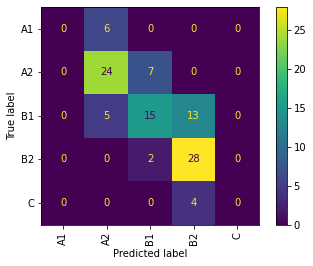

In [ ]:
plot_conf_matrix(conf_per_fold[0],['A1','A2','B1','B2','C']) 

###GRU

In [ ]:
#Architektur 2
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(GRU(embedding_dim,))
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

In [ ]:
################# Training des Modells #####################
#Benennung
architecture = 'GRU (Kl)'
great_acc = []
great_kappa = []
for i in tqdm(range(30)):
  #K-Fold Evaluation
  fold_no = 1
  kappa_per_fold = []
  acc_per_fold = []
  conf_per_fold =[]
  for train, test in kfold.split(input, target):
    x_train = input[train]
    x_test = input[test]

    #Zielvariablen in One Hot Repräsentation umwandeln
    one_hot = convert_to_one_hot(target,target[train])
    encoder = one_hot[1]
    y_train = one_hot[0]
    y_test = target[test]

    #Modell aufrufen und kompilieren
    model = knn_model()

    # Makierung für Start des neuen Durchgangs
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)

    # Auswertung
    score = model_evaluation_classification(x_test,y_test,encoder)
    kappa = score['kappa score']
    acc = score['accuracy']
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
    conf_per_fold.append(score['confusion matrix'])
    print(f'Kappa Score: {kappa}')
    print(f'Acc Score: {acc}%')


    # Fold erhöhen
    fold_no = fold_no + 1
  print(f'Kappa Score: {mean(kappa_per_fold)}')
  print(f'Acc Score: {mean(acc_per_fold)}%')
  great_acc.append(mean(acc_per_fold))
  great_kappa.append(mean(kappa_per_fold))

  0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8349031643560165
Acc Score: 71.15384615384616%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8130880642774078
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6968831786818939
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8037215558793858
Acc Score: 66.99029126213593%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.751456653522453
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score: 0.7787700655663576
Acc Score: 63.10679611650486%
-----------------------------------------------

  3%|▎         | 1/30 [01:17<37:20, 77.25s/it]

Kappa Score: 0.7955458726700557
Acc Score: 60.19417475728155%
Kappa Score: 0.7769829999641885
Acc Score: 63.40365944734877%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8149972632731254
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8342245989304813
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7306967984934087
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8188262885773679
Acc Score: 67.96116504854369%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6936847629599394
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 6 .

  7%|▋         | 2/30 [02:34<35:56, 77.00s/it]

Kappa Score: 0.7513812154696132
Acc Score: 56.310679611650485%
Kappa Score: 0.7741567833857141
Acc Score: 62.048170276325614%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8268156424581006
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8379557494546588
Acc Score: 74.03846153846155%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7554145701159484
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.75926142339605
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.779225061830173
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training f

 10%|█         | 3/30 [03:55<35:39, 79.25s/it]

Kappa Score: 0.7960199004975125
Acc Score: 60.19417475728155%
Kappa Score: 0.7822693761145022
Acc Score: 64.16635548917102%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8539654010334756
Acc Score: 75.96153846153845%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8052237294998987
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7367553567223923
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7748035218341902
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7027059530968129
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training

 13%|█▎        | 4/30 [05:12<33:55, 78.27s/it]

Kappa Score: 0.7937779146773448
Acc Score: 62.13592233009708%
Kappa Score: 0.7731558974240396
Acc Score: 63.010642270351006%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8311516996448504
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8130265050339018
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7693882192403911
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8089628552809665
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7627473562977698
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Trainin

 17%|█▋        | 5/30 [06:34<33:11, 79.66s/it]

Kappa Score: 0.779225061830173
Acc Score: 62.13592233009708%
Kappa Score: 0.774784868346831
Acc Score: 62.91168782673637%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7945858022539793
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8327800829875519
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7588532883642496
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8272311874602348
Acc Score: 71.84466019417476%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7890563461639447
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for 

 20%|██        | 6/30 [07:51<31:27, 78.64s/it]

Kappa Score: 0.8001330598214781
Acc Score: 66.01941747572816%
Kappa Score: 0.7955636663062822
Acc Score: 66.49831964152352%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8381042981925106
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8158403090792015
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7868380234877022
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7723253757736517
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7377103631532329
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training

 23%|██▎       | 7/30 [09:08<29:56, 78.12s/it]

Kappa Score: 0.7890208930766079
Acc Score: 64.07766990291263%
Kappa Score: 0.7903920273745498
Acc Score: 64.07953696788648%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8302872062663185
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8180508387362355
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7949167397020158
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8078178934602108
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7932879919723492
Acc Score: 67.96116504854369%
------------------------------------------------------------------------
Training

 27%|██▋       | 8/30 [10:25<28:31, 77.80s/it]

Kappa Score: 0.7848741343299989
Acc Score: 63.10679611650486%
Kappa Score: 0.7880448293427137
Acc Score: 63.68745332337565%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8125938532385624
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8029266238551427
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7816091954022988
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.777808507107694
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7381355932203391
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training f

 30%|███       | 9/30 [11:42<27:08, 77.56s/it]

Kappa Score: 0.7975515246813051
Acc Score: 66.01941747572816%
Kappa Score: 0.7904598372782132
Acc Score: 64.5631067961165%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8134824348559975
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8371341881178428
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7625570776255708
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.800948699929726
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.799958007453677
Acc Score: 66.99029126213593%
------------------------------------------------------------------------
Training for

 33%|███▎      | 10/30 [12:59<25:46, 77.32s/it]

Kappa Score: 0.7428633452729838
Acc Score: 61.165048543689316%
Kappa Score: 0.7949999871665537
Acc Score: 64.17382374906647%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8171097548360402
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8218068535825545
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7925531914893618
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7183991623523938
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7865168539325843
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training

 37%|███▋      | 11/30 [14:16<24:27, 77.23s/it]

Kappa Score: 0.7746170678336981
Acc Score: 57.28155339805825%
Kappa Score: 0.7805426100193151
Acc Score: 62.90888722927558%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8250488387236814
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8308872581721147
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7165876777251184
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.796370456734425
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7472244945658525
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 6 ...

 40%|████      | 12/30 [15:33<23:07, 77.09s/it]

Kappa Score: 0.7838346876177151
Acc Score: 62.13592233009708%
Kappa Score: 0.7787819147672195
Acc Score: 61.9529499626587%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8038291049702915
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8080073843313719
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7554145701159484
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8017546215478268
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7996724332070837
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training 

 43%|████▎     | 13/30 [16:50<21:49, 77.04s/it]

Kappa Score: 0.7801596139569413
Acc Score: 58.252427184466015%
Kappa Score: 0.7928574520244566
Acc Score: 64.4650858849888%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7926557863501483
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8300053012899806
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7539810754673437
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7895573212258796
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7274058223999099
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training f

 47%|████▋     | 14/30 [18:06<20:31, 76.94s/it]

Kappa Score: 0.768056242104685
Acc Score: 60.19417475728155%
Kappa Score: 0.7769269336048643
Acc Score: 62.53174010455564%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8234295415959253
Acc Score: 71.15384615384616%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6798423839428642
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7048138056312443
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8055977535331216
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6694794390301878
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 50%|█████     | 15/30 [19:23<19:13, 76.89s/it]

Kappa Score: 0.768860867706775
Acc Score: 59.22330097087378%
Kappa Score: 0.7520110302522753
Acc Score: 61.95201643017177%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8371182458888018
Acc Score: 75.96153846153845%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8215686274509804
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.8082429501084599
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7775118220561621
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7097333622371559
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training 

 53%|█████▎    | 16/30 [20:40<17:56, 76.90s/it]

Kappa Score: 0.8044012511170688
Acc Score: 66.99029126213593%
Kappa Score: 0.7876183174803331
Acc Score: 65.61893203883496%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8015489953979122
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8337496253371965
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7269689737470166
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8324401913875599
Acc Score: 66.99029126213593%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7893875881811676
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training

 57%|█████▋    | 17/30 [22:02<17:00, 78.52s/it]

Kappa Score: 0.7788795747290942
Acc Score: 59.22330097087378%
Kappa Score: 0.7835051586726746
Acc Score: 62.91542195668409%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7965571205007824
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.807059767348576
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7817007534983853
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7978999840907885
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7468205621459869
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training

 60%|██████    | 18/30 [23:19<15:36, 78.00s/it]

Kappa Score: 0.7911927018808425
Acc Score: 65.0485436893204%
Kappa Score: 0.7883195551548849
Acc Score: 64.66112770724422%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8185093447421752
Acc Score: 73.07692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.842344618494189
Acc Score: 71.15384615384616%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.765981998615278
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7720333692752965
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.8066713144205502
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training fo

 63%|██████▎   | 19/30 [24:35<14:11, 77.42s/it]

Kappa Score: 0.7638107150302272
Acc Score: 57.28155339805825%
Kappa Score: 0.7850905440503643
Acc Score: 63.48581030619866%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8260675660608763
Acc Score: 74.03846153846155%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7703180212014135
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7586288978814568
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.802028830752803
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7612582781456954
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score:

 67%|██████▋   | 20/30 [25:52<12:51, 77.17s/it]

Kappa Score: 0.7852738966511421
Acc Score: 57.28155339805825%
Kappa Score: 0.7930119210293871
Acc Score: 64.07860343539956%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8378071833648393
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8296943231441047
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.8038370338435008
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7955281579772229
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7391230933753588
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training 

 70%|███████   | 21/30 [27:09<11:33, 77.10s/it]

Kappa Score: 0.7714738510301109
Acc Score: 55.33980582524271%
Kappa Score: 0.7956112448337262
Acc Score: 63.68371919342793%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8224669603524228
Acc Score: 73.07692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.81310886219616
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7374942634235888
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8099046447247
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7190571766764449
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for 

 73%|███████▎  | 22/30 [28:25<10:15, 76.94s/it]

Kappa Score: 0.806882099922797
Acc Score: 66.99029126213593%
Kappa Score: 0.7841448664954127
Acc Score: 63.694921583271096%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.833943833943834
Acc Score: 70.1923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8001130582249859
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7061130334486736
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.786613545816733
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.8065580427389473
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for

 77%|███████▋  | 23/30 [29:42<08:57, 76.85s/it]

Kappa Score: 0.7719977863862756
Acc Score: 53.398058252427184%
Kappa Score: 0.787704311044705
Acc Score: 63.016243465272595%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8398722627737226
Acc Score: 74.03846153846155%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8093161546085232
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7873093079814283
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.768421052631579
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.8216590587124193
Acc Score: 67.96116504854369%
------------------------------------------------------------------------
Training 

 80%|████████  | 24/30 [30:59<07:41, 76.84s/it]

Kappa Score: 0.7758135584222541
Acc Score: 60.19417475728155%
Kappa Score: 0.7826612430083714
Acc Score: 64.6545929798357%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8263537906137184
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8169382418024542
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.708014293006636
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8013500482160077
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.8080808080808081
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training fo

 83%|████████▎ | 25/30 [32:16<06:23, 76.78s/it]

Kappa Score: 0.7726520251627855
Acc Score: 61.165048543689316%
Kappa Score: 0.7871555032364356
Acc Score: 63.794809559372666%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8332498246317266
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8219917012448132
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7581656932727666
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7716985534297713
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7882304564353269
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Traini

 87%|████████▋ | 26/30 [33:32<05:06, 76.74s/it]

Kappa Score: 0.7580739870816207
Acc Score: 53.398058252427184%
Kappa Score: 0.7819525601965671
Acc Score: 63.396191187453326%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8369746252571764
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7858368607710788
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7720836142953473
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7674431411421334
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7427755975740278
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Train

 90%|█████████ | 27/30 [34:48<03:49, 76.58s/it]

Kappa Score: 0.8157623719442788
Acc Score: 67.96116504854369%
Kappa Score: 0.7863239632357565
Acc Score: 65.14283047050037%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7843566409399839
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8122955442752398
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7697024755848285
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6919626168224299
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7655582079609171
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training

 93%|█████████▎| 28/30 [36:05<02:33, 76.59s/it]

Kappa Score: 0.7659090909090909
Acc Score: 61.165048543689316%
Kappa Score: 0.7716553510353712
Acc Score: 64.1719566840926%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8563677616651869
Acc Score: 73.07692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8152958152958153
Acc Score: 69.23076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7753157544870375
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8014288954411432
Acc Score: 66.99029126213593%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7238605898123325
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training

 97%|█████████▋| 29/30 [37:22<01:16, 76.59s/it]

Kappa Score: 0.7930420804868248
Acc Score: 66.01941747572816%
Kappa Score: 0.7871953139852388
Acc Score: 65.33233756534727%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8133565368718729
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8340807174887892
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.8082298136645962
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7888183227484122
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7027059530968129
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training

100%|██████████| 30/30 [38:38<00:00, 77.29s/it]

Kappa Score: 0.7810507136349834
Acc Score: 59.22330097087378%
Kappa Score: 0.7833100974383784
Acc Score: 61.65141896938013%


In [ ]:
model_2 = {
            'konfig':f'{architecture}',
            'acc': mean(great_acc),
            'acc_std': (statistics.stdev(great_acc)),
            'qwk': mean(great_kappa),
            'qwk_std': statistics.stdev(great_kappa),
            'z_acc_per_fold': great_acc,
            'z_qwk_per_fold': great_kappa,
            }
model_2

{'acc': 63.72174508339557,
 'acc_std': 1.1417041100758245,
 'konfig': 'GRU (Kl)',
 'qwk': 0.7835730054756442,
 'qwk_std': 0.008979234804508117,
 'z_acc_per_fold': [63.40365944734877,
  62.048170276325614,
  64.16635548917102,
  63.010642270351006,
  62.91168782673637,
  66.49831964152352,
  64.07953696788648,
  63.68745332337565,
  64.5631067961165,
  64.17382374906647,
  62.90888722927558,
  61.9529499626587,
  64.4650858849888,
  62.53174010455564,
  61.95201643017177,
  65.61893203883496,
  62.91542195668409,
  64.66112770724422,
  63.48581030619866,
  64.07860343539956,
  63.68371919342793,
  63.694921583271096,
  63.016243465272595,
  64.6545929798357,
  63.794809559372666,
  63.396191187453326,
  65.14283047050037,
  64.1719566840926,
  65.33233756534727,
  61.65141896938013],
 'z_qwk_per_fold': [0.7769829999641885,
  0.7741567833857141,
  0.7822693761145022,
  0.7731558974240396,
  0.774784868346831,
  0.7955636663062822,
  0.7903920273745498,
  0.7880448293427137,
  0.790459837

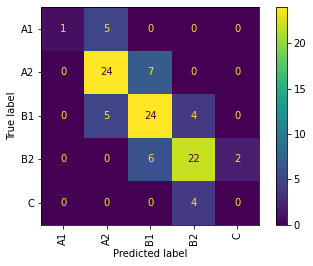

In [ ]:
plot_conf_matrix(conf_per_fold[0],['A1','A2','B1','B2','C']) 

###RNN

In [ ]:
#Architektur 3
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(SimpleRNN(embedding_dim,))
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

In [ ]:
################# Training des Modells #####################
#Benennung
architecture = 'RNN (Kl)'
great_acc = []
great_kappa = []
for i in tqdm(range(30)):
  #K-Fold Evaluation
  fold_no = 1
  kappa_per_fold = []
  acc_per_fold = []
  conf_per_fold =[]
  for train, test in kfold.split(input, target):
    x_train = input[train]
    x_test = input[test]

    #Zielvariablen in One Hot Repräsentation umwandeln
    one_hot = convert_to_one_hot(target,target[train])
    encoder = one_hot[1]
    y_train = one_hot[0]
    y_test = target[test]

    #Modell aufrufen und kompilieren
    model = knn_model()

    # Makierung für Start des neuen Durchgangs
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)

    # Auswertung
    score = model_evaluation_classification(x_test,y_test,encoder)
    kappa = score['kappa score']
    acc = score['accuracy']
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
    conf_per_fold.append(score['confusion matrix'])
    print(f'Kappa Score: {kappa}')
    print(f'Acc Score: {acc}%')


    # Fold erhöhen
    fold_no = fold_no + 1
  print(f'Kappa Score: {mean(kappa_per_fold)}')
  print(f'Acc Score: {mean(acc_per_fold)}%')
  great_acc.append(mean(acc_per_fold))
  great_kappa.append(mean(kappa_per_fold))

In [ ]:
model_3 = {
            'konfig':f'{architecture}',
            'acc': mean(great_acc),
            'acc_std': (statistics.stdev(great_acc)),
            'qwk': mean(great_kappa),
            'qwk_std': statistics.stdev(great_kappa),
            'z_acc_per_fold': great_acc,
            'z_qwk_per_fold': great_kappa,
            }
model_3

In [ ]:
plot_conf_matrix(conf_per_fold[0],['A1','A2','B1','B2','C']) 

##Ausertung

In [ ]:
results = pd.DataFrame([model_1,model_2, model_3] ,columns=['konfig','acc','acc_std','qwk', 'qwk_std'])
results.sort_values('qwk')

In [ ]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/2_2_1_CNN_RNN_Layer_KL.xlsx', engine='xlsxwriter', index=False)  